<a href="https://colab.research.google.com/github/meryamhzamiensi/Quantum-Enhanced-Deep-Learning-for-Precision-Drug-Design-in-Breast-Cancer-Treatment/blob/ML-models/pcd_classic_decision_tree30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory and time count

In [ ]:
def track_memory_usage():
    """
    Track memory usage of the current process

    Returns:
    dict: Memory usage statistics
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    return {
        'rss_mb': memory_info.rss / (1024 * 1024),  # Resident Set Size in MB
        'vms_mb': memory_info.vms / (1024 * 1024),  # Virtual Memory Size in MB
    }

In [ ]:
def calculate_detailed_errors(y_test, y_pred):
    """
    Calculate detailed error metrics

    Parameters:
    y_test (array): True labels
    y_pred (array): Predicted labels

    Returns:
    dict: Error analysis metrics
    """
    # Convert encoded labels back to drug names
    y_test_names = y_test
    y_pred_names = y_pred

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_names, y_pred_names)

    # Detailed error analysis
    error_analysis = {
        'total_samples': len(y_test),
        'misclassified_samples': np.sum(y_test != y_pred),
        'misclassification_rate': 1 - accuracy_score(y_test, y_pred),
        'confusion_matrix': conf_matrix
    }

    # Per-drug error analysis
    drug_error_details = {}
    unique_drugs = np.unique(y_test_names)

    for drug in unique_drugs:
        drug_mask = (y_test_names == drug)
        drug_true = y_test_names[drug_mask]
        drug_pred = y_pred_names[drug_mask]

        drug_error_details[drug] = {
            'total_samples': len(drug_true),
            'correct_predictions': np.sum(drug_true == drug_pred),
            'incorrect_predictions': np.sum(drug_true != drug_pred),
            'accuracy': accuracy_score(drug_true, drug_pred)
        }

    error_analysis['per_drug_details'] = drug_error_details

    return error_analysis

In [ ]:
# Start memory tracking
tracemalloc.start()

# Load Dataset

In [ ]:
# Load the dataset
data = pd.read_csv('/content/GDSC_DATASET.csv')

In [ ]:
# Initial memory snapshot
initial_memory = track_memory_usage()
print("Initial Memory Usage:")
print(f"RSS: {initial_memory['rss_mb']:.2f} MB")
print(f"VMS: {initial_memory['vms_mb']:.2f} MB")

Initial Memory Usage:
RSS: 566.88 MB
VMS: 1954.91 MB


# Pre-processing

In [ ]:
# Filter for breast cancer
breast_cancer_data = data[data['Cancer Type (matching TCGA label)'] == 'BRCA']
breast_cancer_data.drop(['COSMIC_ID','CELL_LINE_NAME','TCGA_DESC','GDSC Tissue descriptor 1','GDSC Tissue descriptor 2','Cancer Type (matching TCGA label)'],axis=1)

,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
91,1003,Camptothecin,0.317741,0.983262,1.403164,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
92,1003,Camptothecin,0.636184,0.969050,1.576546,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
93,1003,Camptothecin,1.235544,0.992326,1.902878,MSS/MSI-L,R,Suspension,Y,Y,Y,TOP1,DNA replication
94,1003,Camptothecin,-2.255899,0.861208,0.001898,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
95,1003,Camptothecin,-3.247021,0.768404,-0.537737,MSS/MSI-L,R,Suspension,Y,Y,Y,TOP1,DNA replication
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241919,2499,N-acetyl cysteine,11.217375,0.984904,1.411075,MSS/MSI-L,R,Adherent,Y,Y,Y,Metabolism,Metabolism
241928,2499,N-acetyl cysteine,9.653037,0.923493,-0.388438,MSS/MSI-L,R,Adherent,Y,Y,Y,Metabolism,Metabolism
241930,2499,N-acetyl cysteine,10.939549,0.980068,1.091482,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,Metabolism,Metabolism
241941,2499,N-acetyl cysteine,9.100781,0.954554,-1.023718,NaN,D/F12,Adherent,Y,Y,N,Metabolism,Metabolism


In [ ]:
    # 2. Drop unnecessary columns
    cols_to_drop = ['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC',
                   'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2',
                   'Cancer Type (matching TCGA label)']
    breast_cancer_data.drop(cols_to_drop, axis=1, inplace=True)

<ipython-input-27-05b89b7c3b5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer_data.drop(cols_to_drop, axis=1, inplace=True)


In [ ]:
    # 3. Handle missing values
    # Categorical columns
    categorical_cols = ['DRUG_NAME', 'Microsatellite instability Status (MSI)',
                       'Screen Medium', 'Growth Properties', 'TARGET_PATHWAY', 'TARGET']
    breast_cancer_data[categorical_cols] = breast_cancer_data[categorical_cols].fillna('Unknown')

    # Binary columns
    binary_cols = ['CNA', 'Gene Expression', 'Methylation']
    breast_cancer_data[binary_cols] = breast_cancer_data[binary_cols].fillna('N')

    # Numeric columns
    numeric_cols = ['DRUG_ID', 'LN_IC50', 'AUC', 'Z_SCORE']
    breast_cancer_data[numeric_cols] = breast_cancer_data[numeric_cols].fillna(0)

<ipython-input-28-37a92af4c45f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer_data[categorical_cols] = breast_cancer_data[categorical_cols].fillna('Unknown')
<ipython-input-28-37a92af4c45f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer_data[binary_cols] = breast_cancer_data[binary_cols].fillna('N')
<ipython-input-28-37a92af4c45f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [ ]:
    # 4. Verify missing values
    missing_after = breast_cancer_data.isnull().sum()
    if missing_after.sum() > 0:
        print("Warning: Missing values remain after cleaning:")
        print(missing_after[missing_after > 0])
    else:
        print("All missing values handled successfully.")

All missing values handled successfully.


In [ ]:
# 5. Save cleaned data if requested

breast_cancer_data.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned data saved to 'cleaned_dataset.csv'")


Cleaned data saved to 'cleaned_dataset.csv'


In [ ]:
# 6. Feature engineering and encoding

# Convert binary columns to numeric (0/1)
binary_mapping = {'N': 0, 'Y': 1}
for col in binary_cols:
    breast_cancer_data[col] = (
        breast_cancer_data[col]
        .map(binary_mapping)
        .fillna(0)
        .astype('int8')
    )


<ipython-input-31-e7aaad4ea7f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer_data[col] = (
<ipython-input-31-e7aaad4ea7f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer_data[col] = (
<ipython-input-31-e7aaad4ea7f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [ ]:

# One-hot encode categorical variables (excluding 'TARGET')
categorical_cols = [col for col in categorical_cols]
breast_cancer_data = pd.get_dummies(
    breast_cancer_data,
    columns=categorical_cols,
    drop_first=True,
    dtype='int8'
)

# Handle infinite values
breast_cancer_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs only in numeric columns using median
numeric_cols = breast_cancer_data.select_dtypes(include=[np.number]).columns
breast_cancer_data[numeric_cols] = breast_cancer_data[numeric_cols].fillna(
    breast_cancer_data[numeric_cols].median()
)


In [ ]:
start_time = time.time()

# Split Data and Scaling

In [ ]:
    from sklearn.preprocessing import LabelEncoder
    # 7. Prepare target variable (binned LN_IC50)
    y = pd.cut(
        breast_cancer_data['LN_IC50'],
        bins=5,
        labels=['very_low', 'low', 'medium', 'high', 'excellent']
    )
    print("\nTarget class distribution:")
    print(y.value_counts())

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # 8. Prepare features
    X = breast_cancer_data.drop(columns=['LN_IC50'])

    # 9. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded  # Maintain class distribution
    )

    print(f"\nFinal dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Target class distribution:
LN_IC50
medium       6726
high         4457
low          1428
very_low      340
excellent     155
Name: count, dtype: int64

Final dataset shapes:
X_train: (10484, 503), y_train: (10484,)
X_test: (2622, 503), y_test: (2622,)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize scaler (fit only on training data)
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data (using same scaling parameters)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (optional, but recommended for column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Memory usage after preprocessing
preprocessing_memory = track_memory_usage()
print("\nMemory Usage after Preprocessing:")
print(f"RSS: {preprocessing_memory['rss_mb']:.2f} MB")
print(f"VMS: {preprocessing_memory['vms_mb']:.2f} MB")


Memory Usage after Preprocessing:
RSS: 429.57 MB
VMS: 1816.64 MB


# Calling and fitting the model

In [ ]:
# Create and train the decision tree classifier
model = DecisionTreeClassifier(max_depth=30, random_state=42)
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=30, random_state=42)

In [ ]:
# Memory usage after training
training_memory = track_memory_usage()
print("\nMemory Usage after Training:")
print(f"RSS: {training_memory['rss_mb']:.2f} MB")
print(f"VMS: {training_memory['vms_mb']:.2f} MB")


Memory Usage after Training:
RSS: 433.17 MB
VMS: 1816.64 MB


# calculating the accuracy and showing the confusion matrix

In [ ]:
# Make predictions
y_pred = model.predict(X_test_scaled)

Accuracy Score: 0.9061784897025171

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        31
           1       0.90      0.87      0.89       892
           2       0.94      0.89      0.91       286
           3       0.90      0.93      0.92      1345
           4       0.93      0.94      0.93        68

    accuracy                           0.91      2622
   macro avg       0.93      0.89      0.91      2622
weighted avg       0.91      0.91      0.91      2622



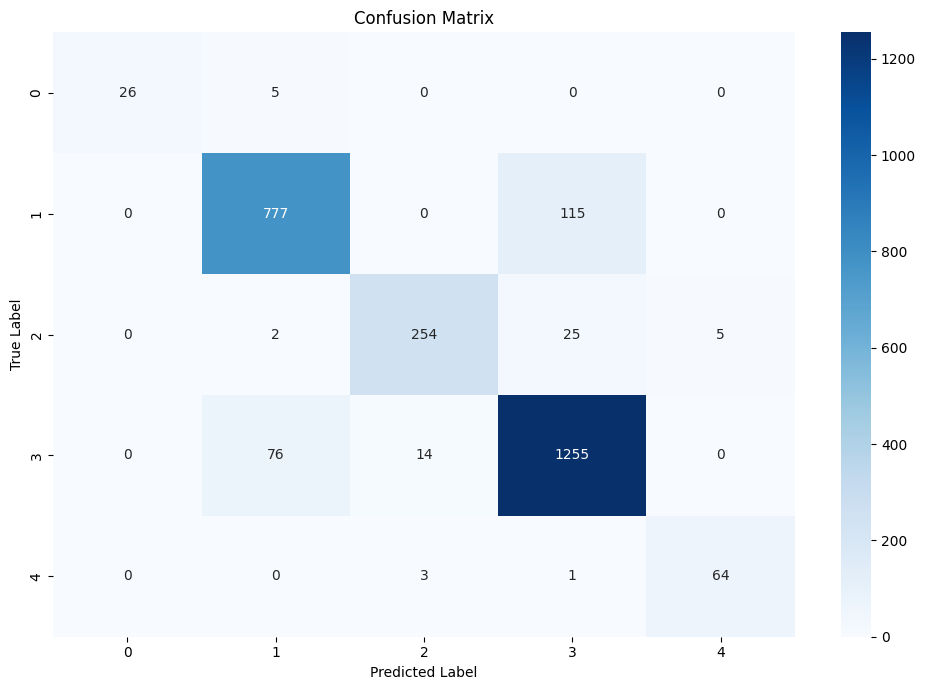

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print model performance
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate detailed error metrics
error_analysis = calculate_detailed_errors(y_test, y_pred)

# Print error analysis
print("\nError Analysis:")
print(f"Total Samples: {error_analysis['total_samples']}")
print(f"Misclassified Samples: {error_analysis['misclassified_samples']}")
print(f"Misclassification Rate: {error_analysis['misclassification_rate']:.4f}")


Error Analysis:
Total Samples: 2622
Misclassified Samples: 246
Misclassification Rate: 0.0938


In [ ]:
# Prediction function
def predict_drug(model, scaler, new_data):
    # Scale the new data
    new_data_scaled = scaler.transform(new_data)
    # Make prediction
    prediction_encoded = model.predict(new_data_scaled)
    # Convert prediction back to drug name
    prediction = drug_encoder.inverse_transform(prediction_encoded)
    return prediction

In [ ]:

# Stop memory tracking and get final snapshot
final_memory = track_memory_usage()
print("\nFinal Memory Usage:")
print(f"RSS: {final_memory['rss_mb']:.2f} MB")
print(f"VMS: {final_memory['vms_mb']:.2f} MB")


Final Memory Usage:
RSS: 433.24 MB
VMS: 1816.64 MB


In [ ]:
# Get memory allocation details
current, peak = tracemalloc.get_traced_memory()
print(f"\nCurrent memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")
tracemalloc.stop()


Current memory usage: 119.43 MB
Peak memory usage: 347.58 MB


In [ ]:
time.sleep(2)  # Simulation d'un traitement

end_time = time.time()  # Arrête le chrono
execution_time = end_time - start_time  # Calcul du temps

print(f"Temps d'exécution : {execution_time:.6f} secondes")

Temps d'exécution : 24.739059 secondes


# Saving the model

In [ ]:
import pickle

with open('decision_tree_30_model.pkl', 'wb') as f:
    pickle.dump(model, f)